In [ ]:
#Quick cell to make jupyter notebook use the full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
#Some plotting libraries
import matplotlib.pyplot as plt
%matplotlib notebook
from bokeh.plotting import show, save, output_notebook, output_file
from bokeh.resources import INLINE 
output_notebook(resources=INLINE)

In [ ]:
from src import workflow
from src.data import Dataset
from src import paths

In [ ]:
import umap
import umap.plot
from vectorizers import NgramVectorizer

In [ ]:
beer_ds = Dataset.load("beer_by_reviewers_simple")
beer = beer_ds.data

## Embed the data

We are going to vectorize our data and look at the number of categorical values they have in common.  A useful thing to do here is to require each row to have a minimum support before being included.  Filtering this early, will ensure indices line up later on.

In [ ]:
popular_beer = beer[beer.review_profilename_len>20].reset_index(drop=True)

In [ ]:
popular_beer.head().T

This next step turns the list of reviewers into a sparse matrix of counts. One row per row of our data frame and one column per unique token that appeared in our categorical field of interest.

We use `min_document_occurrences=20` in our `NgramVectorizer` to only count reviewers who have reviewed at least 20 beers. 

In [ ]:
beer_by_authors_vectorizer = NgramVectorizer(min_document_occurrences=20)
beer_by_authors = beer_by_authors_vectorizer.fit_transform(popular_beer.review_profilename_list)
beer_by_authors

Now we reduce the dimension of this data, and we want a low-dimensional embedding for analysis.

If we are dealing with sets (i.e. just presence or absence of a category) use:<BR>
`metric='jaccard'`<BR>
If we think counts should matter we might use:<BR>
`metric='hellinger'`<BR>
or if we want to correct for very unbalanced column frequencies:<BR>
tfidfVectorizor followed by `metric='hellinger'`<BR>
    
As you get more and more points I'd recommend increasing the `n_neighbors` parameter to compensate.  Thing of this as a resolution parameter.

`n_components` controls the dimension you will be embedding your data into (2-dimensions for easy visualization).  Feel free to embed into higher dimensions for clustering if you'd like.

`unique=True` says that if you have two identical points you want to map them to the exact same co-ordinates in your low space.  This becomes especially important if you have more exact dupes that your `n_neighbors` parameter.  That is the problem case where exact dupes can be pushed into very different regions of your space.

In [ ]:
%%time
beer_by_authors_model = umap.UMAP(n_neighbors=15, n_components=2, metric='jaccard', min_dist=0.3,
                                  unique=True, random_state=42).fit(beer_by_authors)

In [ ]:
path_to_figures = paths['project_path'] / 'reports' / 'figures'
root_filename = 'popular_beer_by_reviewer_jaccard'
outfile_png = path_to_figures / (root_filename + '.png')
outfile_html = path_to_figures / (root_filename + '.html')

In [ ]:
abv_label = popular_beer.beer_abv.fillna(0)
umap_plot = umap.plot.points(beer_by_authors_model, labels=popular_beer.brewery_name, theme='fire', show_legend=False);
umap_plot.figure.savefig(outfile_png, dpi=300, bbox_inches='tight')

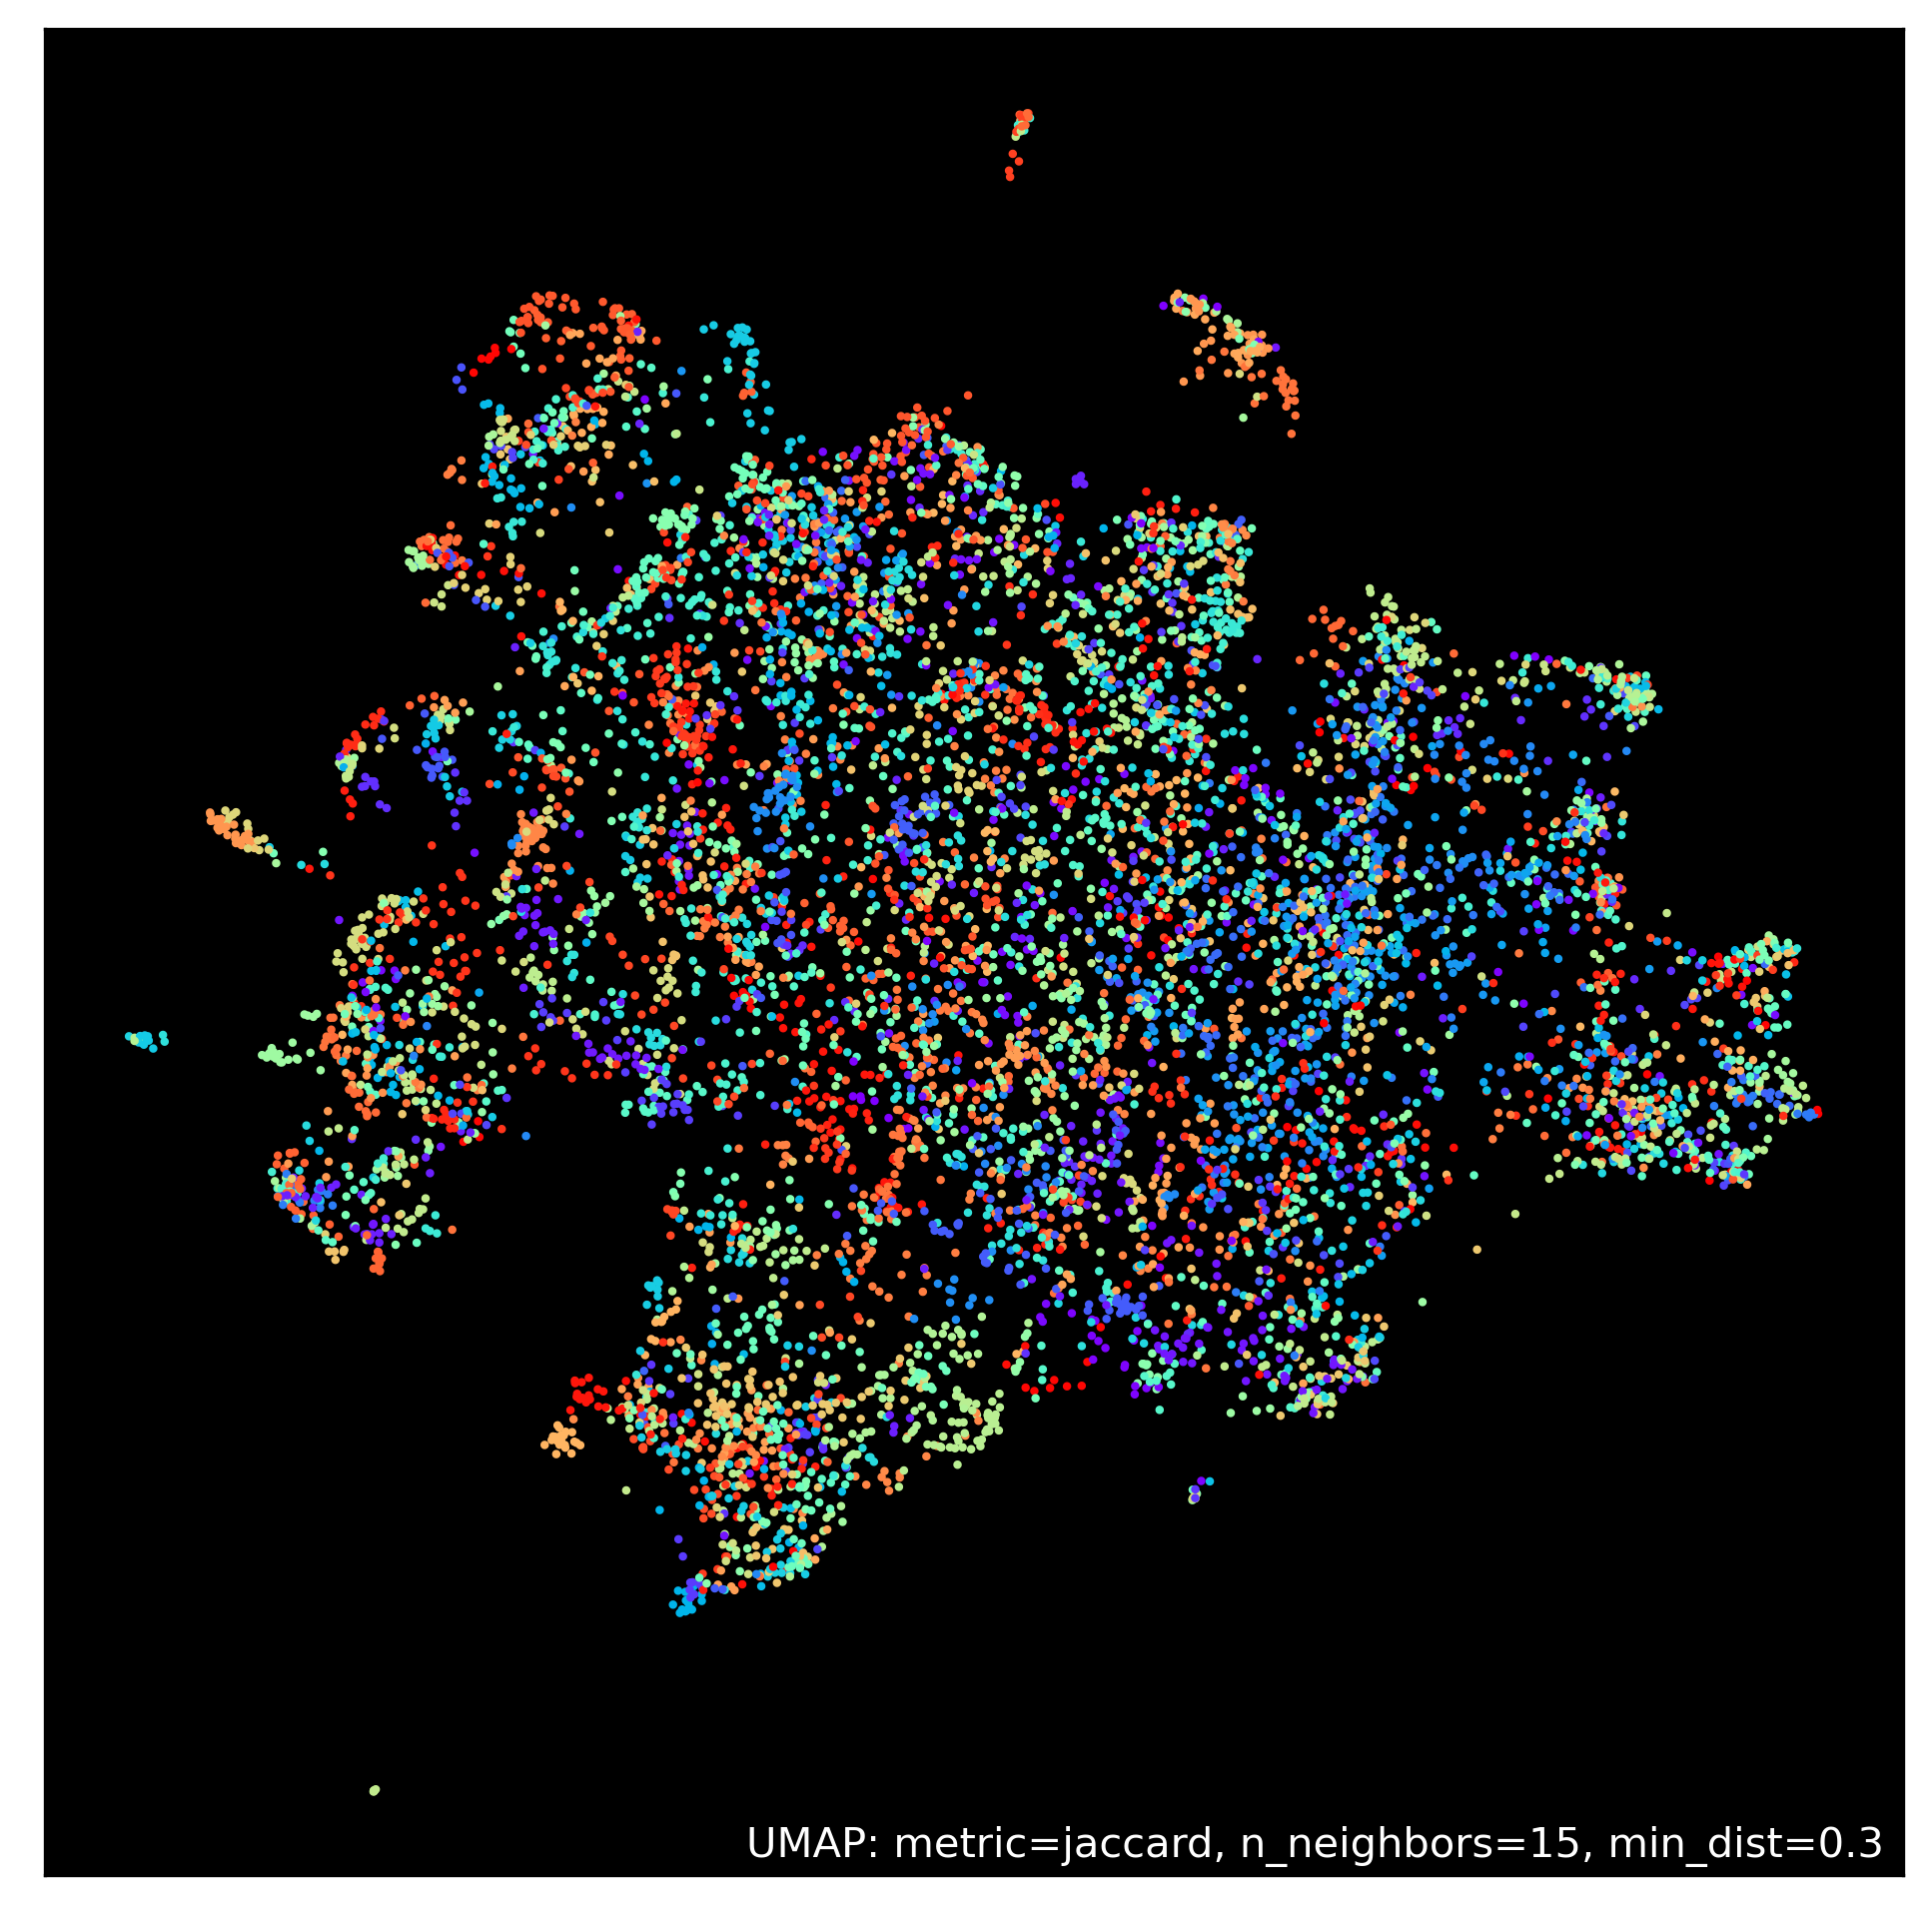
... and now for an interactive plot with mouseover.

In [ ]:
abv_label = popular_beer.beer_abv.fillna(0)
hover_df = popular_beer['beer_beerid beer_name brewery_name beer_style'.split()]
f = umap.plot.interactive(beer_by_authors_model, labels=popular_beer.brewery_name, hover_data=hover_df, theme='fire', point_size=5);
#save(f, filename=outfile_html)
show(f)

It seems that there is a fairly strong tendency to group beers from the same breweries together.  It makes some sense that reviewers tend to sample all the beers from a given brewery (especially if they like the brewery).  

Smaller niche breweries get pulled out of the main cluster as they are reviewed by a small set of individuals who haven't reviewed much else.  Thus they are strongly connected to each other and not to the main cloud.

### What if we wanted to only group beer by the users that liked them?

Are two beers similar if two reviewer tried them?  Perhaps not, instead lets filter to only the reviewers who enjoyed the beer.

Because this is talking about reviewers and not beer we need to filter our initial data frame and re-run our process.

Let's try that next: [10-Data-Beer-by-Reviewer-Positive](10-Data-Beer-by-Reviewer-Positive.ipynb)